In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator


import string
import random
import os
import json
import numpy as np

Using TensorFlow backend.


In [2]:
class ModelConfig():
    """
    This class should contain and any helper
    methods for model lifecycle
    
    input_shape: shape of the input
    steps_per_epoch: total steps for 1 epoch
    epoch: total number of training cycles of the entire training set
    batch_size: chunks of images per iteration to use
    """
    def __init__(self,input_shape,steps_per_epoch=100,batch_size=20,epochs=12,
                 num_classes=10,**kwargs):        
        self.batch_size=batch_size
        self.num_classes=num_classes
        self.epochs=epochs  
        self.steps_per_epoch=steps_per_epoch
        self.input_shape= input_shape
        self.folder_path  =self.log_folder_path()
        self.create_folder()
            
    def random_string(self,n=4):
        """
        Generate string for file name.
        Default is a 4 letter name
        """
        name = ''.join(
            random.choice(
                string.ascii_uppercase + string.digits) for _ in range(n))
        
        return name
    
    def config_to_json(self):
        """
        Create json to to store in file 
        """
        d = dict()
        d["batch_size"] = self.batch_size
        d["num_classes"] = self.num_classes
        d["epochs"] = self.epochs
        j = json.dumps(d)
        return j
    
    def log_folder_path(self):
        """
        Generate folder path for loging model
        """
        folder_path = "./mnist_models/{0}".format(self.random_string())
        print("Folder path: {0}".format(folder_path))
        return folder_path
    
    def create_folder(self):
        """
        Create folder for storing model info
        """
        folder_path =self.folder_path
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        file_path = "{0}/model_config.json".format(folder_path)
        f= open(file_path,"w")
        model_info=self.config_to_json()
        f.write(model_info)
        f.close()
        

class DataSet():
    """
    Class to perform operations on the MNIST data 
    set
    """
    
    def __init__(self,model_config):        
        (x_train, y_train), (x_test, y_test) = mnist.load_data()       
        self.X_train = x_train
        self.Y_train = y_train
        
        self.X_test=x_test
        self.Y_test=y_test
        self.MODEL_CONFIG = model_config
        
        #mem management
        del x_train
        del y_train
        del x_test
        del y_test
        
    def normalize(self,data):
        """
        This function will normalize all values betweem
        0 to 1. Assumes array values range from 0-255
        """
        return data/255.0
    
    def normalize_all_data(self):
        x_train = self.normalize(self.X_train)
        x_test = self.normalize(self.X_test)
        return((x_train,x_test))
    
    def convert_to_categorical(self): 
        """
        Converta categorical classes to 1 hot 
        encoded vectors
        """
        y_train =  keras.utils.to_categorical(self.Y_train,
                                              self.MODEL_CONFIG.num_classes)
        y_test =  keras.utils.to_categorical(self.Y_test,
                                              self.MODEL_CONFIG.num_classes)
        return((y_train,y_test))
        
    def data_preprocess(self):
        x_train,x_test =self.normalize_all_data()
        y_train,y_test = self.convert_to_categorical()   
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        return((x_train,y_train),(x_test,y_test))
        
        
_MODELCONFIG = ModelConfig(epochs=1,input_shape=(28,28,1))

Folder path: ./mnist_models/MRNM


In [3]:
_dataset=DataSet(_MODELCONFIG)

In [4]:
class MNIST:
    """
    Class to build MNIST CNN model
    """
    def __init__(self,data_set):
        self.DATA_SET =data_set
        self.MODEL_CONFIG=data_set.MODEL_CONFIG
        
    def build_model(self):
        """
        Build CNN with regularization 
        """
        inpt_shape = self.MODEL_CONFIG.input_shape
        
        model = Sequential()
        model.add(
            Conv2D(filters=32,
                   kernel_size=(3,3),activation='relu',
                   input_shape=inpt_shape))
        
        model.add(Conv2D(64,(3,3),activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.MODEL_CONFIG.num_classes,
                        activation='softmax'))
        
        return model
    
            
    def run_model(self,print_summary):
        (x_train, y_train), (x_test, y_test)= self.DATA_SET.data_preprocess()

        model=self.train_model_with_gen(x_train,y_train,x_test,y_test)
        if print_summary: print(model.summary())
        self.evaluate_score(model,x_test,y_test)
        
    def train_model_with_gen(self,x_train,y_train,x_test,y_test):
        model = self.build_model()
        
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
        
        #using image generator to save mem 
        tr_gen = ImageDataGenerator(rotation_range=8)
        test_gen = ImageDataGenerator()
        
        train_generator = tr_gen.flow(x_train, y_train,
                                   self.MODEL_CONFIG.batch_size)
        test_generator = test_gen.flow(x_test, y_test, 
                                       self.MODEL_CONFIG.batch_size)

        model.fit_generator(train_generator, 
                            steps_per_epoch=self.MODEL_CONFIG.steps_per_epoch,
                            epochs=self.MODEL_CONFIG.epochs, 
                            validation_data=test_generator,
                            validation_steps=self.MODEL_CONFIG.epochs)
        
        #save model
        model_name = "{0}/model.h5".format(self.MODEL_CONFIG.folder_path)
        model.save(model_name)
        return model
        
    def evaluate_score(self,model,x_test,y_test):
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

In [5]:
mnist_model = MNIST(data_set=_dataset)

In [27]:
mnist_model.run_model(print_summary=True)

Epoch 1/1
100/100 [==============================] - 6s 58ms/step - loss: 1.0462 - acc: 0.6595 - val_loss: 0.4081 - val_acc: 0.9000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1179776   
__________

# Adverserial Examples
This code will derive the minimum set of features required to classify a digit 6 using the features of digit 2

In [6]:
from keras.models import load_model
model_code = "LN2B"
model_path = "./mnist_models/{0}/model.h5".format(model_code)
model = load_model(model_path)

In [7]:
def get_images_classified_as_n(_class=2):
    """
    Get 2 digit images from test set
    """
    
    x_test = _dataset.X_test
    y_test = _dataset.Y_test
    filter_twos = np.where(y_test ==_class)
    x_test= x_test[filter_twos]
    x_test = _dataset.normalize(x_test)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    return x_test

def correctly_classified_images(model,digit_two_images):
    """
    Gets images that are correctly classified as 2
    """
    prediction = model.predict(digit_two_images)
    result = []
    for idx,val in enumerate(prediction):
        pred = np.argmax(val)
        if pred==2:
            img = digit_two_images[idx]
            result.append(img)
            if len(result)==10:
                return np.asarray(result)

In [8]:
correct_class_imgs = get_images_classified_as_n(2)
predicted_imgs= correctly_classified_images(model,correct_class_imgs)

In [9]:
print(len(predicted_imgs))

10


In [27]:
from keras import metrics
def compute_adveserial_noise(correct_img,model,epsilon=10,wrong_class=6,
                 correct_class=2,total_steps=20):
    
    """
    Generate adverserial examples
    
    References:
    1. https://github.com/rodgzilla/machine_learning_adversarial_examples/blob/master/Adversarial%20examples%20-%20detailled%20process.ipynb
    2. https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/11_Adversarial_Examples.ipynb
    """
    
    #init no noise
    noise = 0
    adv_img = None
    for step in range(total_steps):
        
        #add noise to correct_img
        noisy_image = np.float32(correct_img + noise)
        
        #pixel values may be greater than 255 afer addition
        #therefore need to clip
        new_img = np.float32(np.clip(noisy_image, 0., 255.))
        
        #create categorical representation of adveserial class
        target=keras.utils.to_categorical(wrong_class,
                                          _MODELCONFIG.num_classes)      
        target_variable = K.variable(target)
        
        #compute loss for the wrong class
        # https://github.com/rodgzilla/machine_learning_adversarial_examples/blob/master/Adversarial%20examples%20-%20detailled%20process.ipynb
        loss = metrics.categorical_crossentropy(model.output, target_variable)
        gradients  = K.gradients(loss, model.input)
        get_grad_values = K.function([model.input], gradients)
        grad_values = get_grad_values([[new_img]])
        grad_signs = np.sign(grad_values)

        new_pred = model.predict([[new_img.reshape((28,28,1))]])                
        adv_scr=new_pred[0][wrong_class]
        correct_scr =new_pred[0][correct_class]
        grad_absmax = np.abs(grad_values).max()
        adv_pred = np.argmax(new_pred)
#         print("Adverserial score: ",adv_scr)
#         print("Adveserial Prediction score: ",adv_pred)
#         print(new_pred)
#         print()
                
        if adv_scr <=0.99:
            noise -=np.array(grad_signs)[0][0]*epsilon
            adv_img = new_img
        else:
            break
        
    return noise,adv_img
        
        
    

In [38]:
def genereate_adv_imgs(top10_imgs):
    adv_img_list = []
    delta_img_list = []

    for idx,img in enumerate(top10_imgs):
        print("Image#: ",idx)
        noise,adv_img = compute_adveserial_noise(img,model,
                                                 wrong_class=6,epsilon=10,
                               correct_class=2,total_steps=100)
        adv_img_list.append(adv_img)
        delta_img_list.append(noise)
    print("###Done###")
    return adv_img_list,delta_img_list
        
adv_img,noise = genereate_adv_imgs(predicted_imgs)

Image#:  0
Image#:  1
Image#:  2
Image#:  3
Image#:  4
Image#:  5
Image#:  6
Image#:  7
Image#:  8
Image#:  9
###Done###


### Adveserial Images

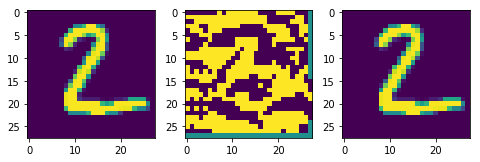

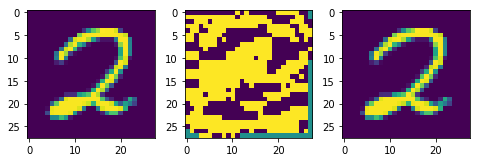

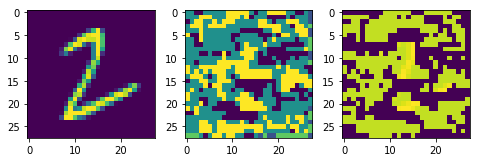

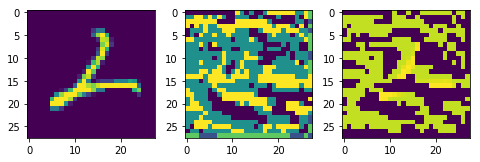

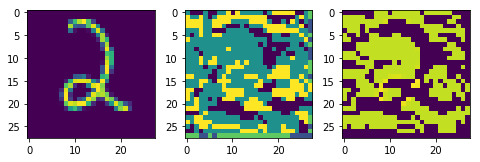

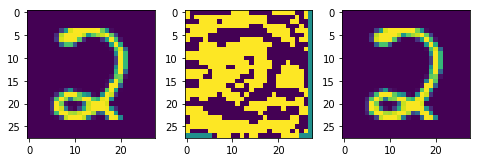

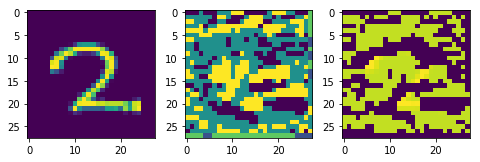

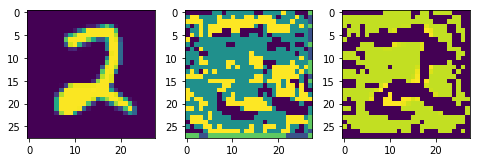

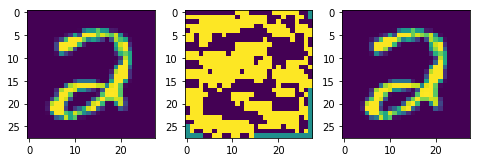

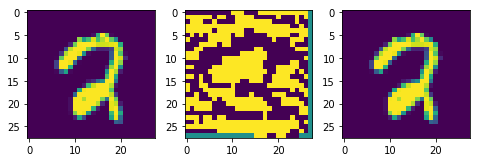

In [60]:
import matplotlib.pyplot as plt


##plotting adveserial examples
w=10
h=10
columns = 3
rows = 5
for i in range(0, 10):
    img =correct_class_imgs[i].reshape((28,28))
    delta = noise[i].reshape((28,28))
    new_img = adv_img[i].reshape((28,28))
    fig=plt.figure(figsize=(8, 8))    
    fig.add_subplot(3, 3, 1)
    
    plt.imshow(img)
    
    fig.add_subplot(3, 3, 2)
    plt.imshow(delta)
    
    fig.add_subplot(3, 3, 3)
    plt.imshow(new_img)
       
plt.savefig("adverserial_examples.png")
plt.show()